In [23]:
import pandas as pd
import numpy as np

In [24]:
#import dataset
df = pd.read_excel('../Dataset/ADAUSDT.xlsx')

#in dòng đầu
df.head()

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
0,28-03-2023,0.346,0.349,0.343,0.348,6754605.6,29-03-2023,2.334081e+06,8143,3444359.8,1.190728e+06,0
1,27-03-2023,0.356,0.357,0.337,0.345,127210336.6,28-03-2023,4.418373e+07,120105,57030489.3,1.981093e+07,0
2,26-03-2023,0.351,0.361,0.349,0.356,91774166.9,27-03-2023,3.265150e+07,72275,43527420.9,1.548775e+07,0
3,25-03-2023,0.360,0.363,0.349,0.351,83603550.1,26-03-2023,2.977094e+07,83654,37953417.1,1.353030e+07,0
4,24-03-2023,0.372,0.372,0.355,0.360,112029219.9,25-03-2023,4.064170e+07,109763,52275535.0,1.897136e+07,0


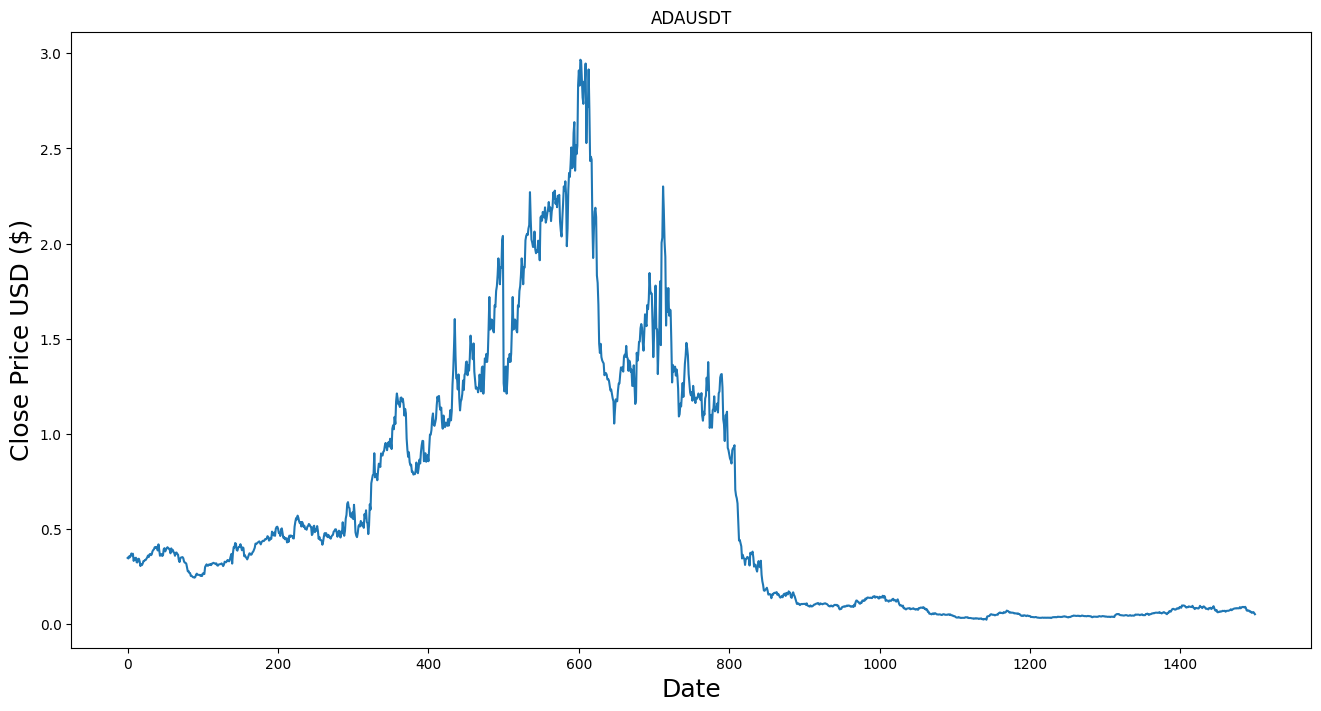

In [25]:
#import thư viện SimpleRNN và MinMaxScaler và LSTM
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

#lấy giá trị đóng cửa
df = df['Close'].values

#vẽ biểu đồ
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.title('ADAUSDT')
plt.plot(df)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()


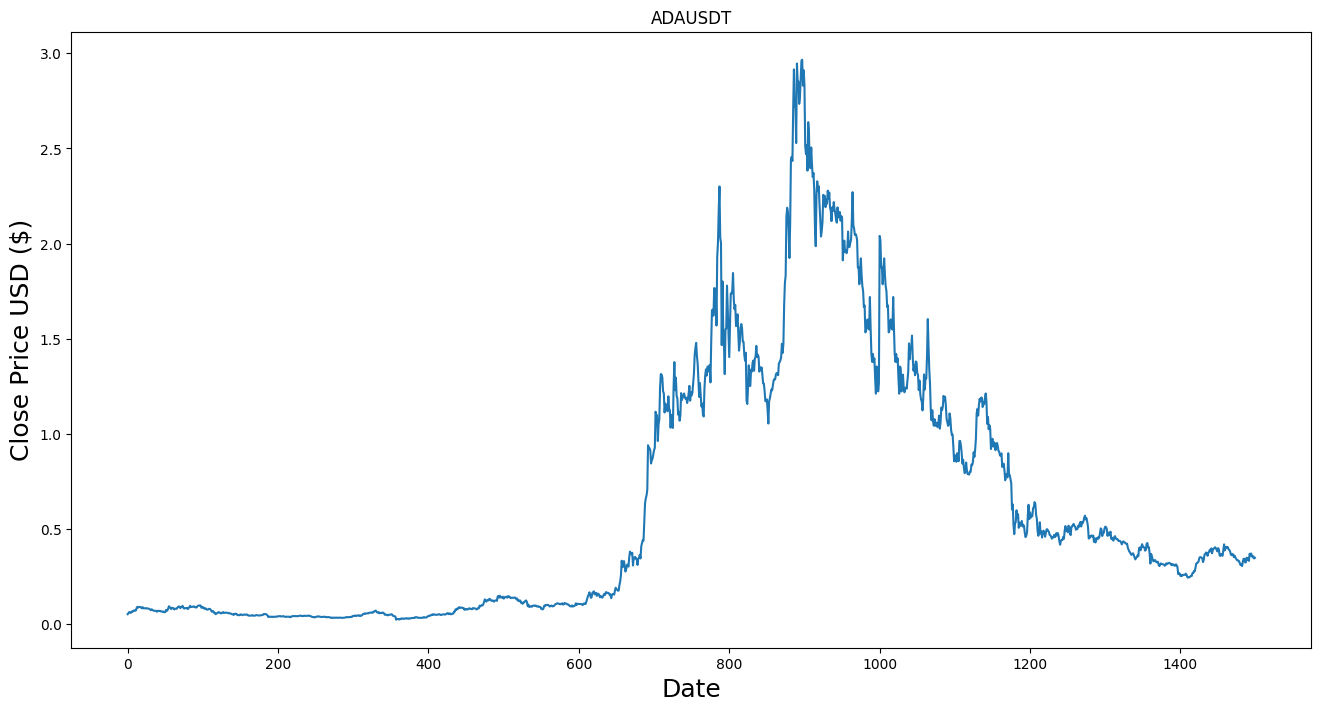

In [26]:
#đảo ngược dữ liệu để chuẩn bị cho mô hình
df = df.reshape(-1, 1)
df = df[::-1]

#vẽ biểu đồ sau khi đảo ngược
plt.figure(figsize=(16,8))
plt.title('ADAUSDT')
plt.plot(df)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()



In [27]:
#chia dữ liệu thành 7 - 2 - 1 (train - validation - test)
train_data = df[:int(df.shape[0]*0.7)]
valid_data = df[int(df.shape[0]*0.7) : int(df.shape[0]*0.8)]
test_data = df[int(df.shape[0]*0.8) : ]

In [28]:
#Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0,1))
train_data = scaler.fit_transform(train_data.reshape(-1,1))
valid_data = scaler.transform(valid_data.reshape(-1,1))
test_data = scaler.transform(test_data.reshape(-1,1))



In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM

# Tạo dữ liệu đầu vào và đầu ra cho model
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# look_back=5
# test_df = [1,2,3,4,5,6,7,8,9,10,11,12]
# testX, testY = create_dataset(test_df, look_back)
# X = [[ 1  2  3  4  5]
#      [ 2  3  4  5  6]
#      [ 3  4  5  6  7]
#      [ 4  5  6  7  8]
#      [ 5  6  7  8  9]
#      [ 6  7  8  9 10]
#      [ 7  8  9 10 11]]
# Y = [ 6  7  8  9 10 11 12]
#và X[0] là giá trị quá khứ của giá trị thực tế Y[0]


look_back = 10 #ta sẽ dự đoán giá trị của ngày tiếp theo dựa trên 10 ngày trước đó
trainX, trainY = create_dataset(train_data, look_back)
valX, valY = create_dataset(valid_data, look_back)
testX, testY = create_dataset(test_data, look_back)

#in ra thông tin của dữ liệu
print(trainX.shape, trainY.shape)
print(valX.shape, valY.shape)
print(testX.shape, testY.shape)

#in ra dòng đầu tiên của dữ liệu
print(trainX[1])
print(trainY[0])
#nhận xét thấy giá trị cuối cùng của trainX[1] = trainY[0]

(1039, 10) (1039,)
(139, 10) (139,)
(289, 10) (289,)
[0.01189263 0.01359157 0.01325178 0.01223242 0.01325178 0.01495073
 0.01461094 0.01630989 0.01664968 0.0159701 ]
0.015970098538905884


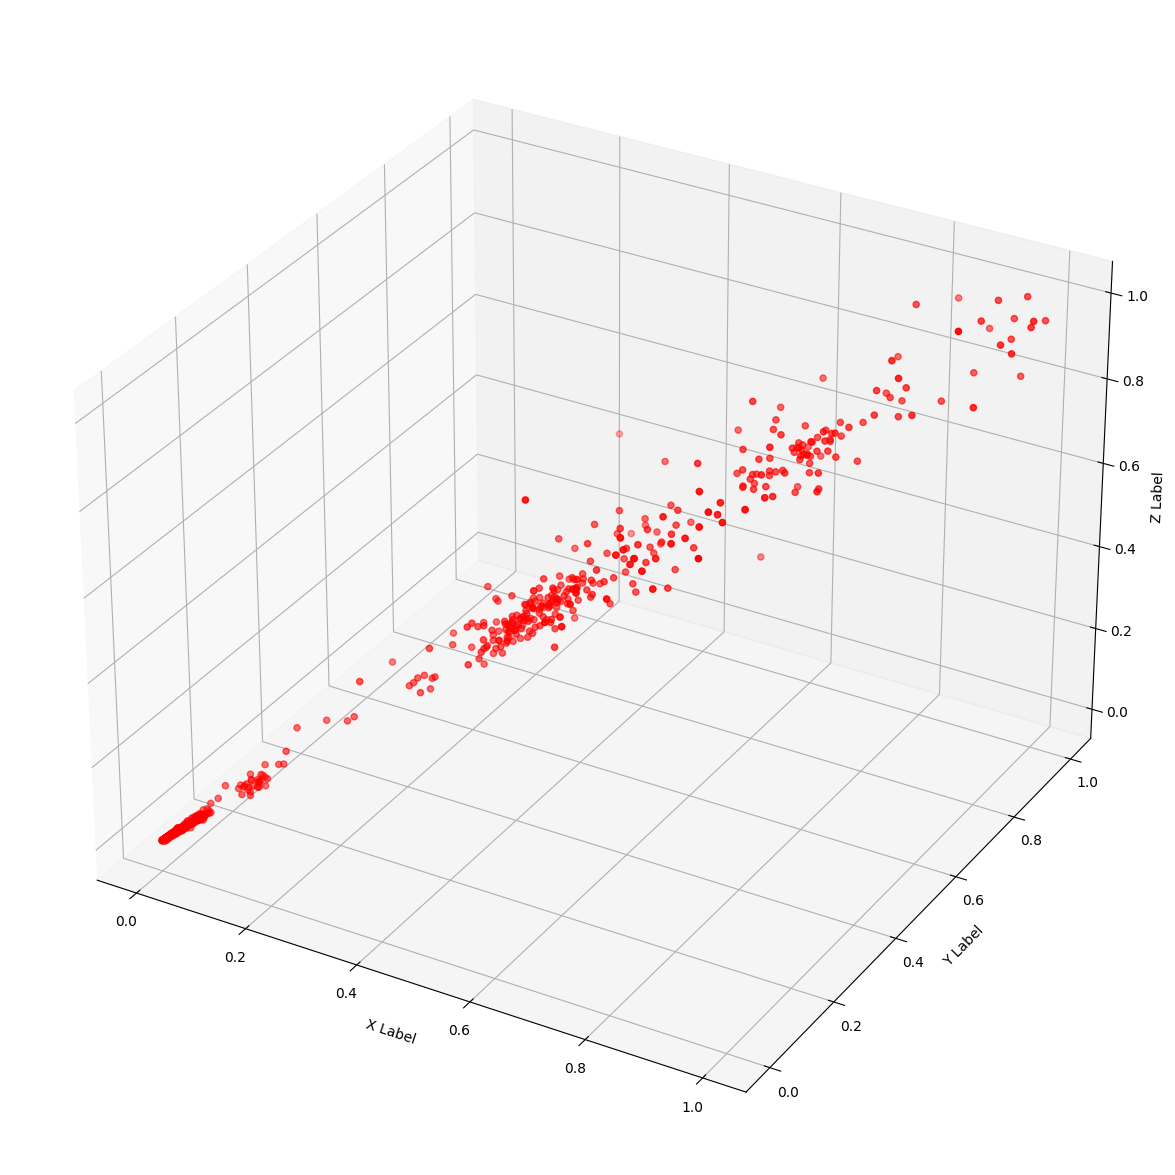

In [30]:
trainX_time_steps = trainX.shape[1] #số lượng hàng của trainX sẽ là số lượng time steps
valX_time_steps = valX.shape[1] #số lượng hàng của valX sẽ là số lượng time steps
testX_time_steps = testX.shape[1] #số lượng hàng của testX sẽ là số lượng time steps

features = 1 #số lượng giá trị của mỗi ngày là 1, ở đây là giá trị đóng cửa "Close"


# Reshape lại đầu vào theo định dạng [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX_time_steps, features))
valX = np.reshape(valX, (valX.shape[0], valX_time_steps, features))
testX = np.reshape(testX, (testX.shape[0], testX_time_steps, features))


#việc định dạng theo [samples, time steps, features] là bắt buộc với LSTM và SimpleRNN, trong đó samples là số lượng dữ liệu
#time steps là khoảng thời gian giữa các dữ liệu, features là số lượng giá trị của mỗi dữ liệu

#trực quan quá 3 chiều của dữ liệu trainX bằng biểu đồ
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111, projection='3d')
# biểu thị dữ liệu mảng 3 chiều của trainX
ax.scatter(trainX[:,0], trainX[:,1], trainX[:,2], c='r', marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()



In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout #thêm thư viện Dropout để tránh overfitting
from tensorflow.keras.callbacks import EarlyStopping


# Tạo model
model = Sequential()

# Thêm một LSTM layer với số lượng unit là 50
input_shape = (trainX_time_steps, features)
model.add(LSTM(50, return_sequences=True, input_shape=input_shape))

# Thêm một LSTM layer với số lượng unit là 50
model.add(LSTM(50))

# Thêm một Dense layer với 32 unit
model.add(Dense(32))

# Thêm một Dropout layer với 0.2 dropout rate
model.add(Dropout(0.2))

# Thêm một Dense layer với 1 unit
model.add(Dense(1))

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

#early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Train model
history = model.fit(trainX, trainY, epochs=100, batch_size=32, verbose=1, validation_data=(valX, valY), callbacks=[early_stopping])




Epoch 1/100
33/33 [==============================] - 5s 35ms/step - loss: 0.0162 - val_loss: 0.0019
Epoch 2/100
33/33 [==============================] - 0s 9ms/step - loss: 0.0036 - val_loss: 0.0017
Epoch 3/100
33/33 [==============================] - 0s 10ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 4/100
33/33 [==============================] - 0s 10ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 5/100
33/33 [==============================] - 0s 10ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 6/100
33/33 [==============================] - 0s 9ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 7/100
33/33 [==============================] - 0s 10ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 8/100
33/33 [==============================] - 0s 9ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 9/100
33/33 [==============================] - 0s 13ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 10/100
33/33 [==============================] - 0s 11ms/step - loss: 0.0025 - val_loss: 0.0015
Ep

In [32]:
#dự đoán dữ liệu
trainPredict = model.predict(trainX)
valPredict = model.predict(valX)
testPredict = model.predict(testX)



10/10 [==============================] - 0s 3ms/step


In [33]:
#đưa dữ liệu về dạng ban đầu
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
valPredict = scaler.inverse_transform(valPredict)

valY = scaler.inverse_transform([valY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])



In [34]:
#tính toán độ lỗi
import math
from sklearn.metrics import mean_squared_error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

valScore = math.sqrt(mean_squared_error(valY[0], valPredict[:,0]))
print('Validation Score: %.2f RMSE' % (valScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))



Train Score: 0.07 RMSE
Validation Score: 0.06 RMSE
Test Score: 0.02 RMSE


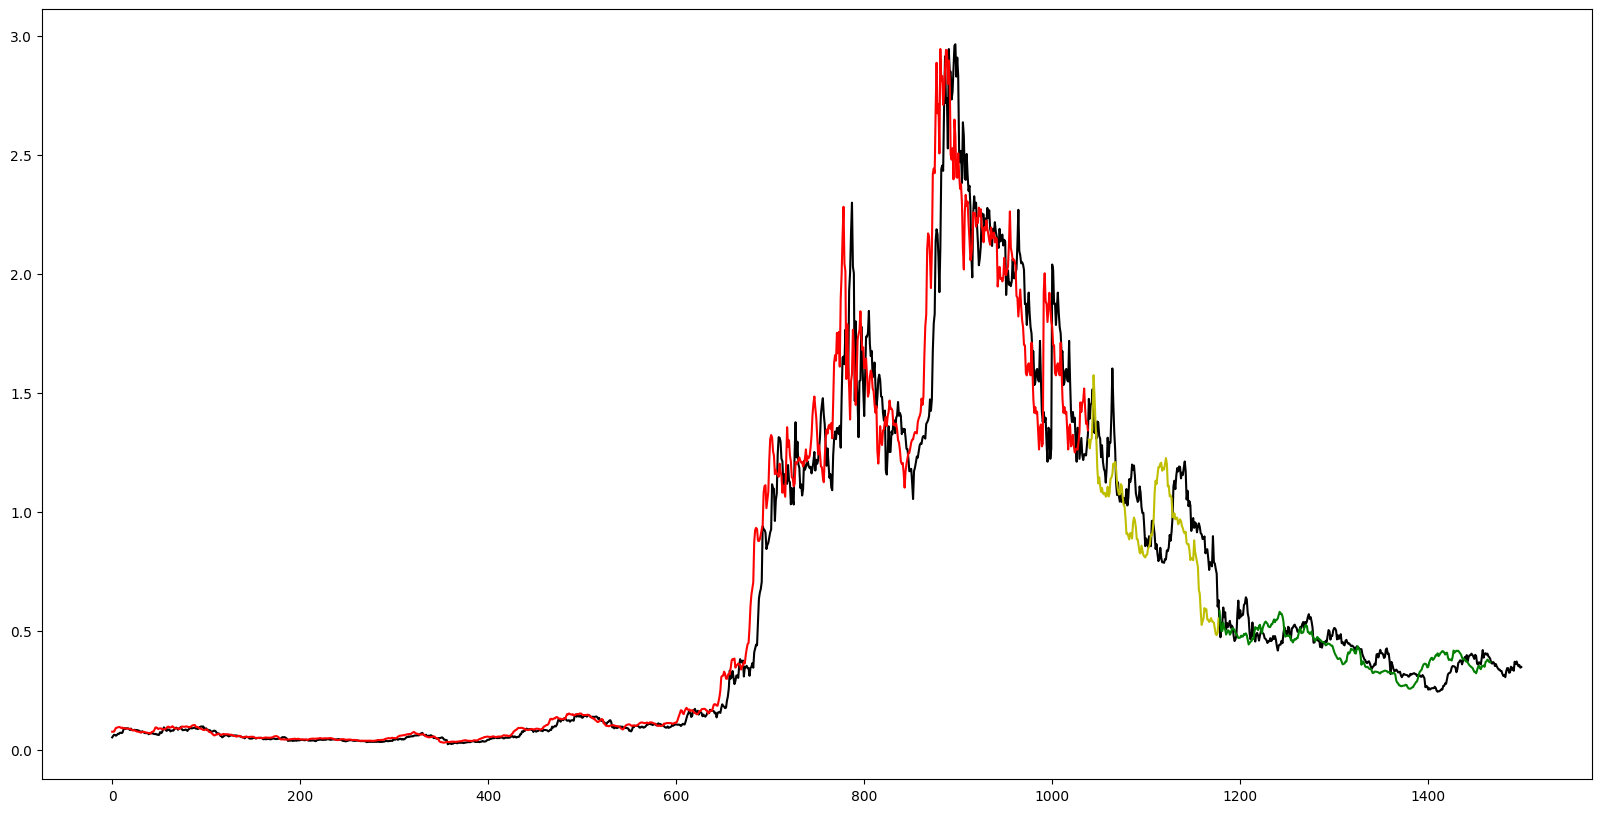

In [35]:
import matplotlib.pyplot as plt

# Tạo một mảng chứa toàn bộ dữ liệu của tập train, validation và test
allPredict = np.concatenate([trainPredict, valPredict, testPredict])

# Tạo mảng index tương ứng với các ngày
days = np.array(range(0, len(allPredict)))

# Vẽ biểu đồ
plt.figure(figsize=(20,10))
plt.plot(df, c='black', label='Real data')
plt.plot(days[:len(trainPredict)], trainPredict, c='r', label='Train')
plt.plot(days[len(trainPredict):len(trainPredict)+len(valPredict)], valPredict, c='y', label='Validation')
plt.plot(days[len(trainPredict)+len(valPredict):], testPredict, c='g', label='Test')
plt.show()

In [36]:
# Chuẩn bị dữ liệu cho dự đoán tiếp theo
last_30_days = df[-30:]
next_30_days = []

look_back = 30

for i in range(30):
    # Tạo input sequence
    input_sequence = last_30_days[-look_back:]
    input_sequence = np.array(input_sequence)

    # Chuẩn hóa dữ liệu
    input_sequence = scaler.transform(input_sequence.reshape(-1, 1))

    # Reshape lại dữ liệu
    input_sequence = input_sequence.reshape(1, look_back, 1)

    # Dự đoán giá tiếp theo
    next_day = model.predict(input_sequence)
    
    # Lưu giá dự đoán
    next_30_days.append(next_day[0][0])

    # Cập nhật input sequence
    last_30_days = np.append(last_30_days, next_day[0][0])

    # Xóa đi phần tử đầu tiên
    last_30_days = np.delete(last_30_days, 0)

    

# Đưa giá trở lại dạng ban đầu
next_30_days = scaler.inverse_transform(np.array(next_30_days).reshape(-1, 1))


1/1 [==============================] - 0s 23ms/step


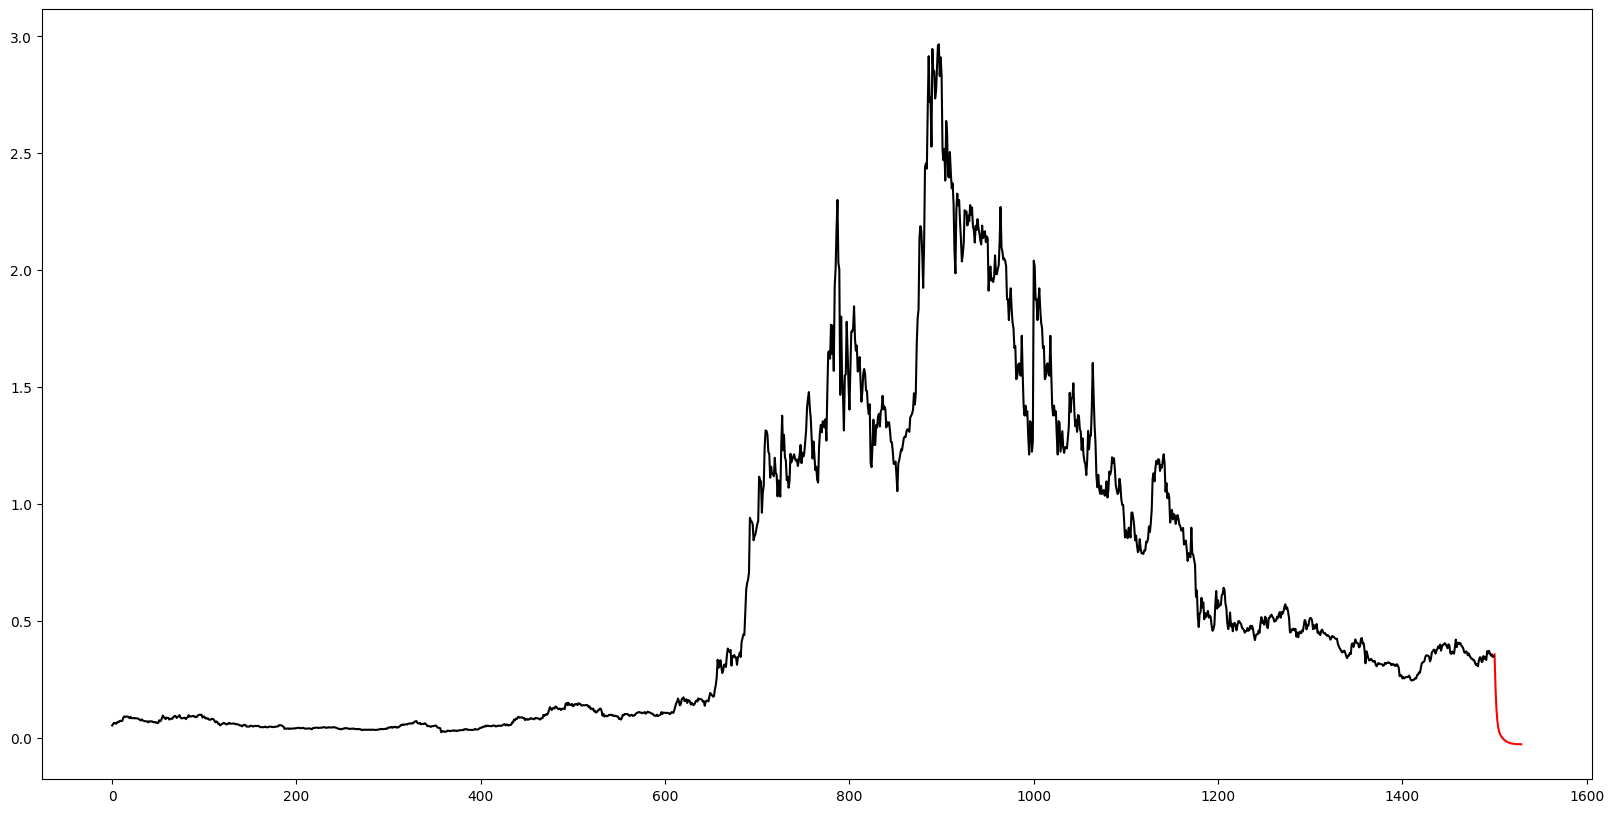

In [37]:
# Tạo mảng index tương ứng với các ngày
days = np.array(range(len(df), len(df) + len(next_30_days)))

# Vẽ biểu đồ
plt.figure(figsize=(20,10))
plt.plot(days, next_30_days, c='r', label='Next 30 days')
plt.plot(df, c='black', label='Real data')
plt.show()
